In [95]:
import warnings
warnings.filterwarnings("ignore")

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# De scikit-learn...

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

# Estandarización y modelado
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import make_column_selector
# Division de los datos
from sklearn.model_selection import train_test_split

# Normalización
from sklearn.preprocessing import MinMaxScaler

# Regresiones
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV, LogisticRegression

# ML metricas
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix

from setuptools import setup
from distutils.core import setup
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
import optuna
from optuna.trial import Trial

In [97]:
path= '/content/drive/MyDrive/weatherAUS.csv'
df = pd.read_csv(path, usecols=range(1,25))
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
### Busco duplicados
if not df.duplicated().any():
  print('No hay registros duplicados')

No hay registros duplicados


In [100]:
class ColDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    return X.drop(['Date'], axis=1)

In [101]:
class LocDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    costa_este = [' Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' ]
    X.loc[X['Location'].isin(costa_este), 'Location'] = 'costa_este'
    return X[X['Location'] == 'costa_este']

In [102]:
class CatFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X['WindGustDir'] = X.groupby('Location')['WindGustDir'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir9am'] = X.groupby('Location')['WindDir9am'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir3pm'] = X.groupby('Location')['WindDir3pm'].transform(lambda x: x.fillna(x.mode()[0]))

      return X

In [103]:
class NumFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      remanining_vnul_columns = X.columns[X.isna().any()].tolist()
      for col in remanining_vnul_columns:
        X[col] =  X[col].fillna(X[col].mean())

      return X

In [104]:
# https://www.mdpi.com/2078-2489/13/4/163 Como las variables de la dirección de los vientos pueden tener hasta 16 direcciones diferentes, para convertirlos a variables numéricas, se tiene encuenta una distribución circular. Por eso, cada una de las variables se dividió en dos: Una con el seno y otra con el coseno del angulo
class CoordRecat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        coord = {
            'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
            'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
            'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
            'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5,
        }

        # Aplicar la recategorización
        for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
            X[col] = X[col].map(coord)
            X[f'{col}_rad'] = np.deg2rad(X[col])
            X[f'{col}_sin'] = np.sin(X[f'{col}_rad']).round(5)
            X[f'{col}_cos'] = np.cos(X[f'{col}_rad']).round(5)

        # Eliminar columnas originales y columnas radianes
        columns_to_drop = [f'{col}_rad' for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']] + ['WindGustDir', 'WindDir9am', 'WindDir3pm']
        X = X.drop(columns=columns_to_drop, axis=1)

        return X

In [105]:
class LocEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      dummies = pd.get_dummies(X['Location'], dtype=int)
      X = pd.concat([X, dummies], axis=1)
      X.drop('Location', axis=1, inplace=True)

      return X

In [106]:
class ResetIndex(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reset_index(drop=True)

In [107]:
class BoolYNDropperEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X.dropna(subset=['RainToday'], inplace=True)
      X['RainTomorrow'] = X['RainTomorrow'].map({'No': 0, 'Yes': 1}).astype(float)
      X['RainToday'] = X['RainToday'].map({'No': 0, 'Yes': 1}).astype(float)

      return X

In [108]:
class Standarizer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    # Exclusión de variables booleanas y RainfallTmorrow porque no serán estandarizaradas
    exc_c = ['RainToday', 'RainTomorrow']#, ,'Canberra','Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

    # Estandarización
    df_sub = X[[col for col in X.columns if col not in exc_c]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_sub)

    X_scaled = pd.DataFrame(X_scaled, columns=df_sub.columns)
    for col in exc_c:
      X_scaled[f'{col}'] = X[col]

    # Nuevo DataFrame estandarizado con los nombres de las columnas originales
    return X_scaled

In [109]:
class OutliersTreater(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    cols_with_ouliers=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']

    for col in cols_with_ouliers:
      IQR=X[col].quantile(0.75)-X[col].quantile(0.25)
      lower_bridge=X[col].quantile(0.25)-(IQR*1.5)
      upper_bridge=X[col].quantile(0.75)+(IQR*1.5)

      X.loc[X[col]>=round(upper_bridge,2),col]=round(upper_bridge,2)
      X.loc[X[col]<=round(lower_bridge,2),col]=round(lower_bridge,2)

    return X


In [110]:
class RLValDropper(BaseEstimator, TransformerMixin):
  def fit (self, X, y=None):
    return self
  def transform(self, X):
    X.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)
    return X


In [111]:
preprocessor = Pipeline([
     ('drop_null_val_rl', RLValDropper()),
     ('drop_not_needed_features', ColDropper()),
     ('drop_nor_needed_locations',LocDropper()),
     ('yes_no_dropper_encoder', BoolYNDropperEncoder()),
     ('fill_null_cat', CatFiller()),
     ('fill_num_cat', NumFiller()),
     ('encode_loc', LocEncoder()),
     ('encode_wind_dir', CoordRecat()),
     ('reset_index',ResetIndex()),
     ('treat_outliers',OutliersTreater()),
     ('standariza_values', Standarizer())
])


# Train-Test split

In [112]:
# Separación de variables explicativas y variables objetivo
X = df.drop(['RainfallTomorrow'], axis=1).copy()
y = df[['RainfallTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((116329, 23), (29083, 23), (116329, 1), (29083, 1))

In [113]:
# Creo un Dataframe de TRAIN
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainfallTomorrow'] = y['RainfallTomorrow']

In [114]:
# Creo un Dataframe de TEST
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['RainfallTomorrow'] = y['RainfallTomorrow']

In [115]:
# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.fit_transform(df_test)

In [116]:
X_train_regresion = df_train.drop(['RainfallTomorrow', 'RainTomorrow'], axis=1)
y_train_regresion = df_train['RainfallTomorrow']

In [117]:
X_test_regresion = df_test.drop(['RainfallTomorrow', 'RainTomorrow'], axis=1)
y_test_regresion = df_test['RainfallTomorrow']

In [118]:
def objective_reg(trial: Trial):
    # Create the model
    model = Sequential()

    # Define hyperparameters to optimize
    num_layers = trial.suggest_int('num_layers', 1, 5)
    num_units_input = trial.suggest_int('n_units_input', 4, 128)
    model.add(Dense(num_units_input, activation='relu', input_shape=(X_train_regresion.shape[1],)))

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128)
        model.add(Dense(num_units, activation='relu'))
        dropout_rate = trial.suggest_float(f'dropout_rate_layer_{i}', 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear'))  # Output layer for regression

    # Compile the model
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Split the data into training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_regresion, y_train_regresion, test_size=0.2, random_state=42)


    # Train the model
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=64, verbose=0)

    # Evaluate the model
    score = model.evaluate(X_valid, y_valid, verbose=0)
    return score

In [119]:

# Run the Optuna optimization with a limited number of trials for a mockup run
study = optuna.create_study(direction='minimize')  # Minimize the loss
study.optimize(objective_reg, n_trials=10)

[I 2024-06-07 00:11:38,018] A new study created in memory with name: no-name-f8d8936a-4a93-4b15-962a-418ae1363eb0
[I 2024-06-07 00:11:49,240] Trial 0 finished with value: 0.6286141276359558 and parameters: {'num_layers': 3, 'n_units_input': 77, 'n_units_layer_0': 28, 'dropout_rate_layer_0': 0.34521331866131433, 'n_units_layer_1': 110, 'dropout_rate_layer_1': 0.2681376812625076, 'n_units_layer_2': 45, 'dropout_rate_layer_2': 0.1437431331046981, 'learning_rate': 0.0027756792404580463}. Best is trial 0 with value: 0.6286141276359558.
[I 2024-06-07 00:12:00,862] Trial 1 finished with value: 0.6820784211158752 and parameters: {'num_layers': 4, 'n_units_input': 31, 'n_units_layer_0': 69, 'dropout_rate_layer_0': 0.018642497970850658, 'n_units_layer_1': 16, 'dropout_rate_layer_1': 0.17049702587761578, 'n_units_layer_2': 61, 'dropout_rate_layer_2': 0.24500922968024186, 'n_units_layer_3': 20, 'dropout_rate_layer_3': 0.18869522400175148, 'learning_rate': 0.000280780728961587}. Best is trial 0 wit

In [120]:
# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)

Best parameters: {'num_layers': 3, 'n_units_input': 77, 'n_units_layer_0': 28, 'dropout_rate_layer_0': 0.34521331866131433, 'n_units_layer_1': 110, 'dropout_rate_layer_1': 0.2681376812625076, 'n_units_layer_2': 45, 'dropout_rate_layer_2': 0.1437431331046981, 'learning_rate': 0.0027756792404580463}


In [121]:
# Train the best model on the entire training data
best_model = Sequential()
best_model.add(Dense(best_params['n_units_input'], activation='relu', input_shape=(X_train_regresion.shape[1],)))


for i in range(best_params['num_layers']):
    best_model.add(Dense(best_params[f'n_units_layer_{i}'], activation='relu'))
    best_model.add(Dropout(best_params[f'dropout_rate_layer_{i}']))

best_model.add(Dense(1, activation='linear'))

In [122]:
# Compile the best model
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')

In [123]:
# Train the best model
best_model.fit(X_train_regresion, y_train_regresion, epochs=10, batch_size=64, verbose=0)

In [124]:
X_test_regresion

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Temp9am,Temp3pm,costa_este,WindGustDir_sin,WindGustDir_cos,WindDir9am_sin,WindDir9am_cos,WindDir3pm_sin,WindDir3pm_cos,RainToday
0,1.537261,1.019470,-0.632975,0.388774,1.188415,0.607450,-0.032009,1.426797,0.353163,0.769235,...,1.453347,0.963325,0.0,1.320022,0.869645,-0.392244,1.061069,1.183771,1.059246,0.0
1,0.836018,0.732462,-0.132392,0.744493,1.130197,0.017658,0.202022,0.167420,-1.543735,-1.097595,...,0.578185,0.978937,0.0,0.174634,1.245777,-1.348059,-0.188410,1.629413,0.111074,0.0
2,-0.378330,1.321584,-0.632975,1.029068,1.508611,2.584719,-0.968133,2.514440,-1.766900,-1.803963,...,0.875740,1.494115,0.0,-0.445238,1.148023,0.792785,-1.437888,-0.968014,1.059246,0.0
3,1.383330,1.110104,-0.132392,-0.322663,1.421284,0.297290,-0.500071,0.625376,-0.260540,0.163776,...,1.435844,1.213108,0.0,1.320022,0.869645,0.200270,1.164016,1.513594,0.624214,0.0
4,2.324022,2.832153,-0.632975,2.451944,1.363067,-0.400570,-1.319180,-0.862979,-2.045856,-1.854418,...,2.739834,2.805477,0.0,0.794505,1.148023,-1.348059,-0.188410,0.107878,1.451985,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,-0.788814,0.385031,-0.632975,0.531062,1.392176,-0.090410,-1.319180,-1.549911,0.074207,-0.845321,...,0.000579,0.432536,0.0,1.794451,-0.038433,-0.894568,0.767904,0.690139,1.349915,0.0
4745,-0.446744,-0.536416,-0.632975,-0.251520,-0.761868,-0.943350,-1.787242,-0.634001,0.576327,0.062867,...,-0.524518,-0.519763,0.0,-0.970755,-0.946510,0.200270,1.164016,-1.297837,-0.402066,0.0
4746,-0.207295,1.170527,-0.632975,0.602206,1.741480,-0.710730,-0.734102,-0.862979,0.185789,-0.693956,...,0.245624,1.228720,0.0,0.174634,-1.322642,1.630740,-0.705956,0.107878,-1.229838,0.0
4747,0.254499,-0.204091,1.869938,-0.536095,1.246632,1.150229,0.202022,0.854353,-1.711109,-0.946231,...,0.123102,-0.176311,0.0,-0.445238,-1.224888,-0.894568,-1.144723,0.690139,-1.127768,1.0


In [125]:
# Evaluate the best model
train_scores = best_model.evaluate(X_train_regresion, y_train_regresion, verbose=0)
valid_scores = best_model.evaluate(X_test_regresion, y_test_regresion, verbose=0)

train_r2 = r2_score(y_train_regresion, best_model.predict(X_train_regresion))
valid_r2 = r2_score(y_test_regresion, best_model.predict(X_test_regresion))

train_mse = mean_squared_error(y_train_regresion, best_model.predict(X_train_regresion))
valid_mse = mean_squared_error(y_test_regresion, best_model.predict(X_test_regresion))

149/149 [==============================] - 0s 2ms/step


In [126]:
print(f"Train R2: {train_r2}, Test R2: {valid_r2}")
print(f"Train MSE: {train_mse}, Validation MSE: {valid_mse}")

Train R2: 0.37097447564668906, Test R2: 0.31679286421628194
Train MSE: 0.6290255243533108, Validation MSE: 0.6832071357837181


In [127]:
#pip install shap

In [128]:
import shap

In [129]:
X_train_regresion

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Temp9am,Temp3pm,costa_este,WindGustDir_sin,WindGustDir_cos,WindDir9am_sin,WindDir9am_cos,WindDir3pm_sin,WindDir3pm_cos,RainToday
0,-0.095229,1.403916,-0.420677,0.129130,-0.329659,1.711644,0.740400,1.181787,-2.439476,-0.569634,...,1.424959,1.101909,0.0,-0.942834,0.862325,0.215495,1.148342,-1.285854,0.614786,0.0
1,1.328003,2.268189,-0.625474,1.677469,-1.066479,1.110961,1.193486,-0.161767,-1.277913,-1.575068,...,2.045610,2.347640,0.0,-1.412712,-0.054022,0.812661,1.045490,-0.466322,1.342701,0.0
2,-0.685350,-1.219227,-0.625474,-0.926556,-0.565441,0.285021,0.966943,-0.049804,0.326149,0.888246,...,-1.217240,-1.187121,0.0,-1.290594,-0.549939,-1.344991,-0.202840,-0.466322,-1.142541,0.0
3,-0.164655,0.297041,-0.625474,-0.574661,0.908197,-1.892456,-0.958674,-1.281396,0.160212,-0.720449,...,0.165925,0.494615,0.0,-1.412712,-0.054022,1.318930,-1.158275,0.692652,1.342701,0.0
4,1.171795,0.039275,1.934487,0.340267,-2.009607,0.585363,1.986387,0.845898,1.155836,0.687159,...,0.485116,0.089753,0.0,1.325975,-0.970369,0.812661,-1.451171,1.512184,-0.414626,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19221,1.310647,0.236390,-0.215880,0.762541,-0.801224,2.500041,2.382838,-1.617284,-0.337601,1.943952,...,1.318562,-0.299538,0.0,-1.290594,-0.549939,0.215495,1.148342,1.627451,0.100080,0.0
19222,-0.112586,-0.582394,0.398510,-0.926556,0.407160,0.059765,0.740400,0.621973,-0.005726,-0.318275,...,-0.366062,-0.548684,0.0,-0.942834,0.862325,-0.381672,1.045490,-0.957602,1.051145,0.0
19223,0.043623,1.024849,-0.625474,0.129130,0.525051,-0.841260,-1.525031,-0.609619,-0.614163,-1.122623,...,0.396452,1.117481,0.0,0.191571,-1.349927,1.318930,-1.158275,-0.466322,1.342701,0.0
19224,0.564318,0.297041,-0.625474,1.184816,-0.771751,2.237242,2.382838,2.077490,-0.226976,0.335257,...,0.378719,0.307756,0.0,0.191571,1.241883,0.215495,1.148342,0.113165,1.445083,0.0


PermutationExplainer explainer: 4750it [15:03,  5.23it/s]


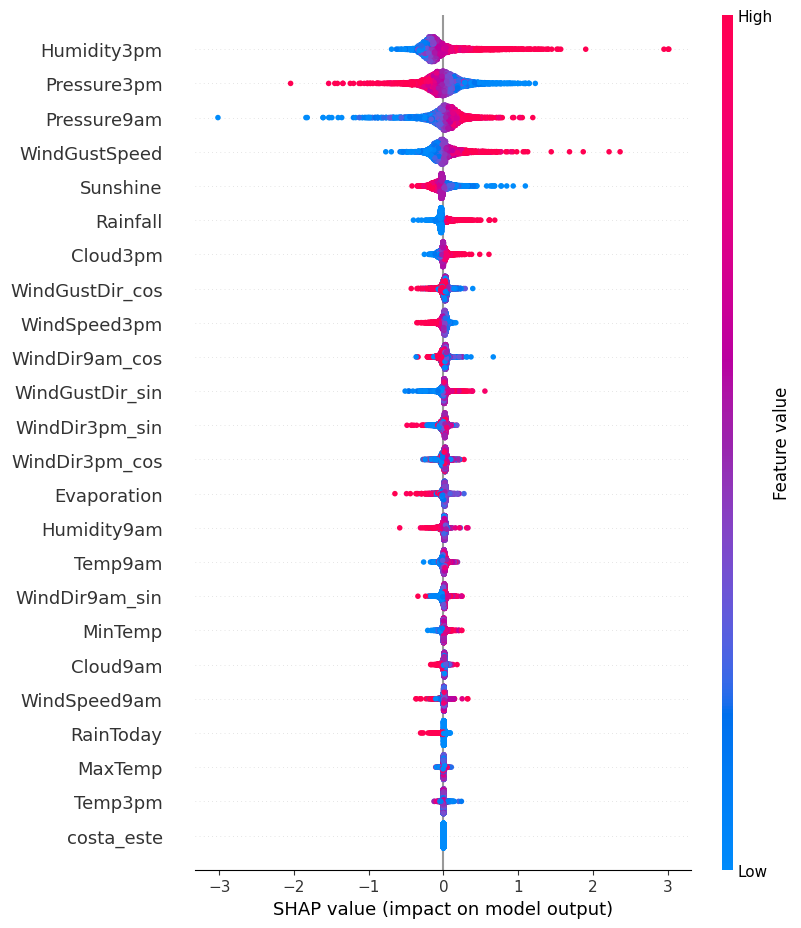

In [130]:
explainer = shap.Explainer(best_model,
                            X_train_regresion.values,
                            feature_names=X_train_regresion.columns)

explanation = explainer(X_test_regresion)

shap.plots.beeswarm(explanation, max_display=None)

# Agregar explicabilidad par el modelo de regresión lineal

Para las redes neuronales, las variables mas explicativas son La humedad de las 3pm, La presion de las 3pm y la presion de las 9am. Tanto la presión como la humedad, a mayor valor mayor es la cantidad de lluvia que predice mi modelo. En cambio para la presion de las 3pm a mayor valor, en el modelo resta la cantidad de lluvia.

In [ ]:
x_train_array = X_train_regresion.values
x_test_array = X_test_regresion.values

# Crea el explainer usando DeepExplainer
explainer = shap.DeepExplainer(best_model, x_train_array)

# Obtén las explicaciones para x_test_reg
explanation = explainer.shap_values(x_test_array)


shap.summary_plot(explanation, x_test_array, feature_names=X_train_regresion.columns)